# Multimodal UAV Pipeline 





In [35]:
# === Config ===
LOCAL_IMG_DIR = "/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front"  # point to your extracted town folder
N_SAMPLES = 160                     # deterministic: first N files
BATCH_SIZE = 16
OUTPUT_DIR = "./outputs"
MODE = "HYBRID"                     # "HYBRID" tries CLIP + SegFormer; else fallback to ResNet18 + stats
SEED = 42
D_LLM = 1024                        # adapter output dim (just for shape demo)

import os, glob, numpy as np, torch
from PIL import Image
import matplotlib.pyplot as plt

os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.manual_seed(SEED); np.random.seed(SEED)

# Gather image files (recursive), deterministic order
exts = ("*.jpg","*.jpeg","*.png","*.bmp")
paths = []
for root, _, _ in os.walk(LOCAL_IMG_DIR):
    for ext in exts:
        paths.extend(glob.glob(os.path.join(root, ext)))
paths = sorted(paths)
assert len(paths) > 0, f"No images found in {LOCAL_IMG_DIR}."
paths = paths[:min(N_SAMPLES, len(paths))]
print(f"Using {len(paths)} images from: {LOCAL_IMG_DIR}")
print("Sample paths:", paths[:5])


Using 160 images from: /Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front
Sample paths: ['/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front/000000.png', '/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front/000001.png', '/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front/000002.png', '/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front/000003.png', '/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01/town01_20241217_215934/rgb/Front/000004.png']


## Preview of images

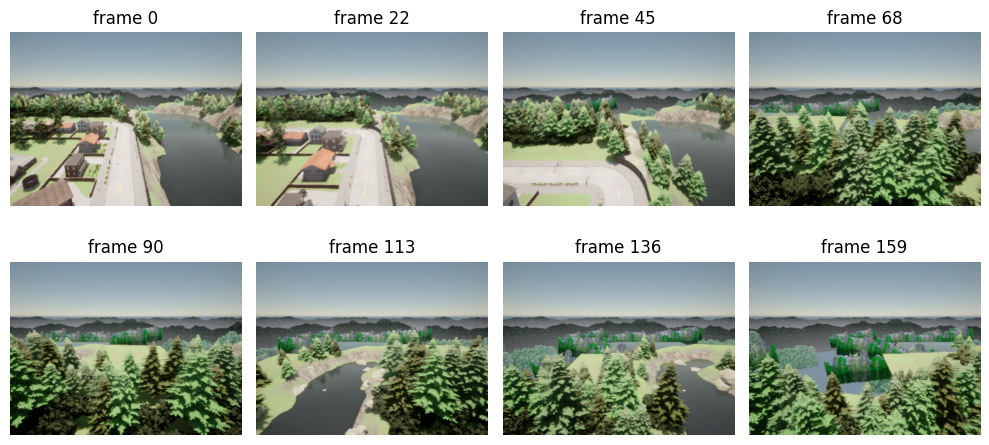

In [36]:
show_k = min(8, len(paths))
idxs = np.linspace(0, len(paths)-1, show_k).astype(int)  # evenly spaced, deterministic
fig = plt.figure(figsize=(10,5))
for i, idx in enumerate(idxs):
    ax = plt.subplot(2, (show_k+1)//2, i+1)
    ax.imshow(Image.open(paths[idx]).convert("RGB"))
    ax.set_title(f"frame {idx}")
    ax.axis("off")
plt.tight_layout(); plt.show()


## Vision Encoder: BLIP‑2 Proxy (CLIP ViT‑B/32)
We treat the CLIP/ResNet penultimate features as **E_img**.


In [26]:
from torchvision import models, transforms
import torch.nn as nn

DEVICE = torch.device("cpu")

# Standard normalization (works for ResNet; acceptable for CLIP transforms fallback if needed)
preproc_vision = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def _resnet18_backbone():
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
    resnet.eval()
    return nn.Sequential(*list(resnet.children())[:-1]).to(DEVICE), 512

clip_model = None
clip_preproc = None
vision_backbone = None
Dv = 512  # vision feature dim

if MODE == "HYBRID":
    try:
        import open_clip
        clip_model, _, clip_preproc = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=DEVICE)
        clip_model.eval()
        Dv = clip_model.visual.output_dim
        print("Vision: CLIP ViT-B/32 via open-clip, Dv =", Dv)
    except Exception as e:
        print("open_clip unavailable:", e)
        try:
            import clip
            clip_model, clip_preproc = clip.load("ViT-B/32", device=str(DEVICE))
            clip_model.eval()
            Dv = clip_model.visual.output_dim
            print("Vision: CLIP ViT-B/32 via openai-clip, Dv =", Dv)
        except Exception as e2:
            print("openai-clip unavailable:", e2)
            vision_backbone, Dv = _resnet18_backbone()
            print("Vision: ResNet18 fallback, Dv =", Dv)
else:
    vision_backbone, Dv = _resnet18_backbone()
    print("Vision: ResNet18, Dv =", Dv)

def vision_embed_batch(batch_paths):
    if clip_model is not None and clip_preproc is not None:
        imgs = [clip_preproc(Image.open(p).convert("RGB")) for p in batch_paths]
        x = torch.stack(imgs, dim=0).to(DEVICE)
        with torch.no_grad():
            feat = clip_model.encode_image(x)     # [B, Dv]
        return feat
    else:
        imgs = [preproc_vision(Image.open(p).convert("RGB")) for p in batch_paths]
        x = torch.stack(imgs, dim=0).to(DEVICE)
        with torch.no_grad():
            feat = vision_backbone(x).view(x.size(0), -1)  # [B, Dv]
        return feat


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /laion/CLIP-ViT-B-32-laion2B-s34B-b79K/resolve/main/open_clip_model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x15082ddd0>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: c5e8aee0-48a7-4931-89d8-d06e7cfdc54f)')' thrown while requesting HEAD https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /laion/CLIP-ViT-B-32-laion2B-s34B-b79K/resolve/main/open_clip_model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x32290c650>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: f42466e3-11c8-42a6-8

Vision: CLIP ViT-B/32 via open-clip, Dv = 512


## SegFormer: Scene Context (E_scene) 


In [27]:
import numpy as np, torch
segformer_ok = False
Ds = 50  # default scene descriptor dim if fallback stats are used

# Fallback scene stats (50-D): RGB hists + edge density + blur metric
def scene_context_batch_lite(batch_paths):
    descs = []
    for p in batch_paths:
        img = Image.open(p).convert("RGB").resize((256,256))
        arr = np.asarray(img)
        bins = 16
        h_r, _ = np.histogram(arr[:,:,0], bins=bins, range=(0,255), density=True)
        h_g, _ = np.histogram(arr[:,:,1], bins=bins, range=(0,255), density=True)
        h_b, _ = np.histogram(arr[:,:,2], bins=bins, range=(0,255), density=True)
        gy, gx = np.gradient(arr.mean(axis=2).astype(np.float32))
        edge_density = float((np.hypot(gx, gy) > 10).mean())
        lap = np.abs(
            np.roll(arr.mean(axis=2), 1, axis=0) +
            np.roll(arr.mean(axis=2), -1, axis=0) +
            np.roll(arr.mean(axis=2), 1, axis=1) +
            np.roll(arr.mean(axis=2), -1, axis=1) -
            4*arr.mean(axis=2)
        )
        blur_metric = float(lap.var() / (1e-5 + arr.mean()))
        desc = np.concatenate([h_r, h_g, h_b, [edge_density, blur_metric]], axis=0).astype(np.float32)
        descs.append(desc)
    return torch.tensor(np.stack(descs, axis=0))

# Try SegFormer (model + processor). If available, use its global descriptor and show segmentation.
seg_processor = None
seg_model = None
seg_vis_model = None  # for masks

try:
    from transformers import SegformerImageProcessor, SegformerModel, SegformerForSemanticSegmentation
    seg_processor = SegformerImageProcessor(do_resize=True, size=512, do_normalize=True)
    seg_model = SegformerModel.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    seg_model.eval()
    Ds = seg_model.config.hidden_sizes[-1]  # typically 256
    segformer_ok = True
    try:
        seg_vis_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        seg_vis_model.eval()
    except Exception as _:
        seg_vis_model = None
    print("SegFormer OK. Ds =", Ds)
except Exception as e:
    print("SegFormer unavailable; using scene stats. Reason:", e)

def scene_context_batch(batch_paths):
    if segformer_ok:
        imgs = [Image.open(p).convert("RGB") for p in batch_paths]
        inputs = seg_processor(images=imgs, return_tensors="pt")
        with torch.no_grad():
            out = seg_model(**{k:v for k,v in inputs.items()})
        last = out.last_hidden_state  # [B, L, C]
        desc = last.mean(dim=1)       # [B, C] global scene descriptor
        return desc
    else:
        return scene_context_batch_lite(batch_paths)


SegFormer OK. Ds = 256


### SegFormer sample masks (first 4 frames)

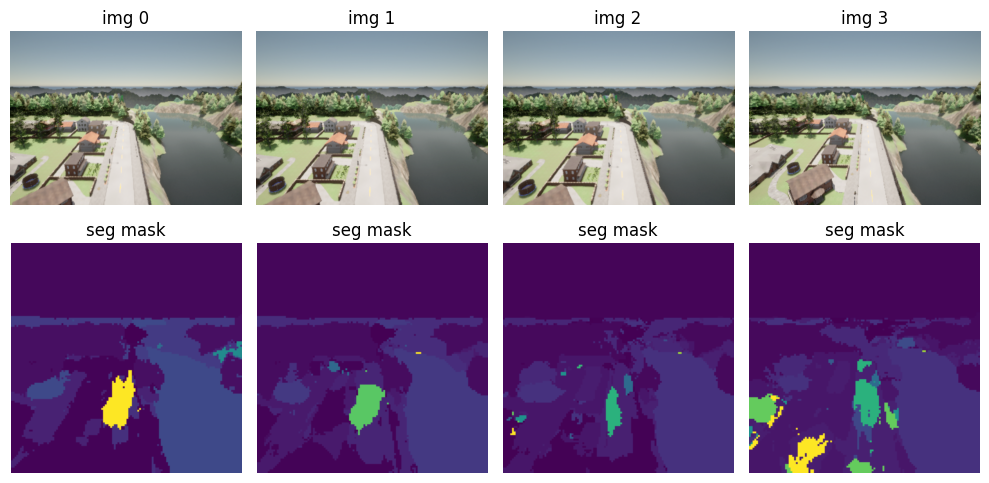

In [28]:
if segformer_ok and seg_vis_model is not None:
    import torch, numpy as np, matplotlib.pyplot as plt
    k = min(4, len(paths))
    imgs = [Image.open(paths[i]).convert("RGB") for i in range(k)]
    inputs = seg_processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        out = seg_vis_model(**{k:v for k,v in inputs.items()})
    logits = out.logits  # [B, num_labels, H, W]
    preds = logits.argmax(dim=1).cpu().numpy()
    fig = plt.figure(figsize=(10,5))
    for i in range(k):
        ax = plt.subplot(2, k, i+1); ax.imshow(imgs[i]); ax.axis("off"); ax.set_title(f"img {i}")
        ax2 = plt.subplot(2, k, k+i+1); ax2.imshow(preds[i]); ax2.axis("off"); ax2.set_title("seg mask")
    plt.tight_layout(); plt.show()


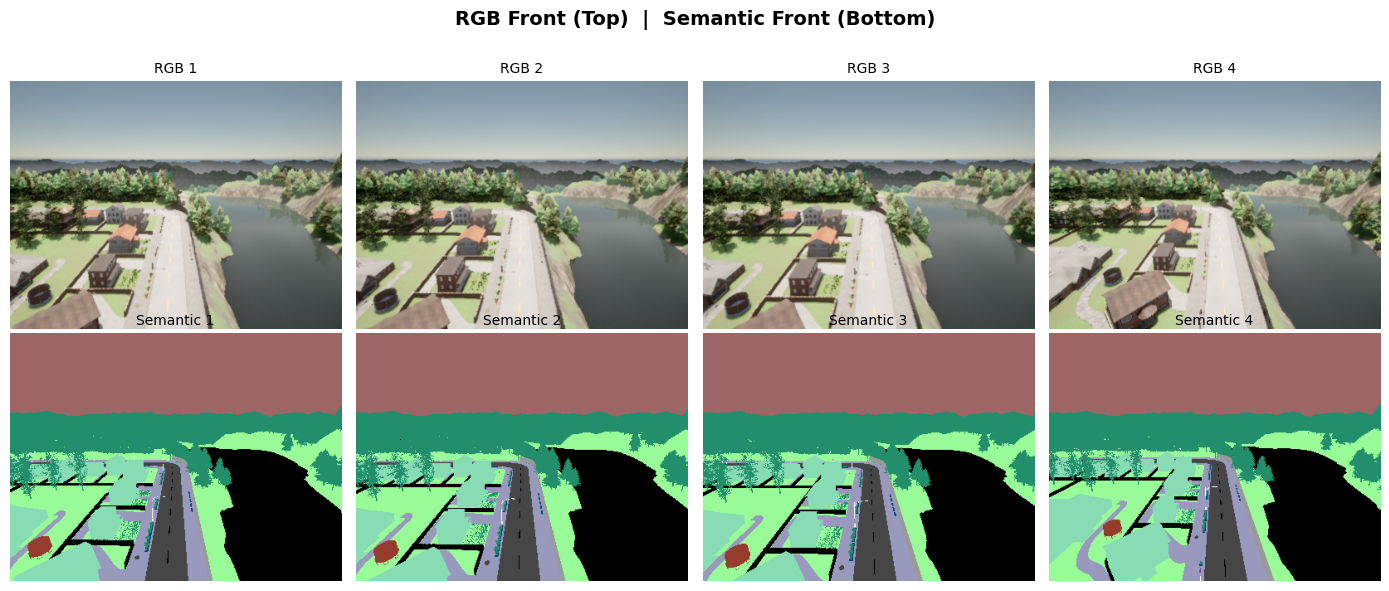

In [47]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os

# --- Paths ---
rgb_dir = "uav_data/town01/town01_20241217_215934/rgb/Front"
sem_dir = "uav_data/town01/town01_20241217_215934/semantic/Front"

# --- Get file lists ---
rgb_images = sorted(glob.glob(os.path.join(rgb_dir, "*.png")))[:4]
sem_images = sorted(glob.glob(os.path.join(sem_dir, "*.png")))[:4]

# --- Safety check ---
assert len(rgb_images) == len(sem_images), "RGB and Semantic counts differ!"

# --- Plot ---
fig, axes = plt.subplots(2, len(rgb_images), figsize=(14, 6))
fig.suptitle("RGB Front (Top)  |  Semantic Front (Bottom)", fontsize=14, weight='bold')

for i in range(len(rgb_images)):
    # Top row — RGB
    rgb_img = Image.open(rgb_images[i]).convert("RGB")
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"RGB {i+1}", fontsize=10)
    axes[0, i].axis("off")

    # Bottom row — Semantic
    sem_img = Image.open(sem_images[i]).convert("RGB")
    axes[1, i].imshow(sem_img)
    axes[1, i].set_title(f"Semantic {i+1}", fontsize=10)
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Telemetry -> MLP -> 512
We pass telemetry `[altitude, velocity, roll, pitch, yaw, battery]` through a small MLP (**h_tel**).


In [48]:
# --- Telemetry MLP + robust CSV loader (drop-in fix) ---
import os
import torch, torch.nn as nn
import numpy as np
import pandas as pd

TEL_DIM = 6
DEVICE = torch.device("cpu")  # or your existing DEVICE

class TelemetryMLP(nn.Module):
    def __init__(self, in_dim=TEL_DIM, hid=256, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(inplace=True),
            nn.Linear(hid, out_dim)
        )
    def forward(self, x):
        return self.net(x)

tel_mlp = TelemetryMLP().to(DEVICE).eval()

# Point to your CSV (spaces in path are fine)
TELEMETRY_CSV = r"/Users/meena/Desktop/PROJECTS/llm for uav/CODE/telemetry_newdata.csv"

def load_or_make_telemetry(n):
    """Loads telemetry; if CSV shorter than n, trims global `paths` to keep alignment.
       Normalizes column names + coerces to numeric."""
    global paths  # so we can keep image/telemetry lengths in sync
    if TELEMETRY_CSV and os.path.exists(TELEMETRY_CSV):
        df = pd.read_csv(TELEMETRY_CSV)

        # normalize column names
        df.columns = [c.strip().lower() for c in df.columns]
        # common aliases -> required names
        alias = {
            "alt": "altitude", "alt_m": "altitude", "height": "altitude",
            "vel": "velocity", "speed": "velocity"
        }
        df = df.rename(columns=alias)

        needed = ["altitude","velocity","roll","pitch","yaw","battery"]
        missing = [c for c in needed if c not in df.columns]
        assert not missing, f"Telemetry CSV missing columns: {missing} (need {needed})"

        # coerce to numeric and drop NaNs
        for c in needed:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df = df.dropna(subset=needed)

        m = len(df)
        if m < n:
            print(f"[WARN] telemetry rows ({m}) < frames ({n}); truncating frames to {m} for alignment.")
            if 'paths' in globals():
                paths = paths[:m]
            n = m

        tel = df.loc[:n-1, needed].to_numpy(dtype=np.float32)
    else:
        # deterministic (no randomness)
        t = np.arange(n, dtype=np.float32)
        altitude = 80 + 15*np.sin(2*np.pi * t/120) + 5*np.sin(2*np.pi * t/37)
        velocity = 5 + 1.5*np.cos(2*np.pi * t/50)
        roll     = 4*np.sin(2*np.pi * t/45)
        pitch    = 3*np.cos(2*np.pi * t/60)
        yaw      = (t*3) % 360
        battery  = np.maximum(100 - 0.15*t, 0)
        tel = np.stack([altitude, velocity, roll, pitch, yaw, battery], axis=1).astype(np.float32)

    # normalize per channel
    tel = (tel - tel.mean(axis=0)) / (tel.std(axis=0) + 1e-6)
    tel = torch.tensor(tel, device=DEVICE)
    print("Telemetry raw:", tel.shape)
    print("Telemetry head (first row):", tel[0].detach().cpu().numpy())
    return tel

# Usage:
tel_raw = load_or_make_telemetry(len(paths))  # aligns with your image list length
t = tel_mlp(tel_raw)  # -> [N, 512]
print("Telemetry embedding (MLP) shape:", t.shape)
print("t[0,:8] =", t[0,:8].detach().cpu().numpy())


Telemetry raw: torch.Size([160, 6])
Telemetry head (first row): [-0.26100433  1.3341758  -0.12603332  1.4617133  -1.4095472   1.7212594 ]
Telemetry embedding (MLP) shape: torch.Size([160, 512])
t[0,:8] = [-0.5431537   0.06403233  0.25631937  0.20038357  0.36456215  0.31534034
 -0.10825024 -0.39743796]


## Merge Vision Embeddings (concat + Linear → 512)
Compute **E_img** and **E_scene**, concatenate them, and map to **h_vis**.
Separate 512-D projections for scene and telemetry for traceability.


In [30]:
import torch.nn.functional as F, torch, torch.nn as nn

# Linear layers for merging and projecting
merge_vis = nn.Linear(Dv + (seg_model.config.hidden_sizes[-1] if 'seg_model' in globals() and segformer_ok else 50), 512).to(DEVICE).eval()
proj_img  = nn.Linear(Dv, 512).to(DEVICE).eval()
proj_scene= nn.Linear((seg_model.config.hidden_sizes[-1] if 'seg_model' in globals() and segformer_ok else 50), 512).to(DEVICE).eval()
proj_tel  = nn.Identity()  # tel_mlp already outputs 512; keep explicit to show step

class GatedFusion(nn.Module):
    def __init__(self, d=512):
        super().__init__()
        self.gate = nn.Linear(3*d, d)  # followed by sigmoid
    def forward(self, himg, hscene, htel):
        x = torch.cat([himg, hscene, htel], dim=1)
        g = torch.sigmoid(self.gate(x))  # [B,512]
        H = F.relu(g*himg + (1-g)*(hscene + htel))
        return H, g

fusion = GatedFusion().to(DEVICE).eval()
print("Layers ready: merge_vis, proj_img, proj_scene, proj_tel (Identity), fusion")


Layers ready: merge_vis, proj_img, proj_scene, proj_tel (Identity), fusion


## Batch Embedding -> Merge -> Project-> **Gated Fusion**
Prints shapes and first 8 dims at each point.


In [31]:
# --- FIXED: embed -> sanitize scene -> (re)build linears -> merge/project -> gated fusion ---
def iterate_in_batches(lst, bs):
    for i in range(0, len(lst), bs):
        yield lst[i:i+bs]

Eimg_list, Escene_list, himg_list, hscene_list, htel_list = [], [], [], [], []

for b, batch_paths in enumerate(iterate_in_batches(paths, BATCH_SIZE)):
    with torch.no_grad():
        # 1) encoders
        Eimg = vision_embed_batch(batch_paths)          # [B, Dv]
        Escn = scene_context_batch(batch_paths)         # [B, Ds] or [B, L, C] or [B, C, H, W]
        t_idx = [paths.index(p) for p in batch_paths]
        tel  = tel_mlp(tel_raw[t_idx])                  # [B, 512]

        # 2) sanitize scene to 2-D [B, Ds_meas]
        if Escn.dim() == 4:        # [B, C, H, W] -> [B, C]
            Escn = Escn.mean(dim=(2,3))
        elif Escn.dim() == 3:      # [B, L, C] -> [B, C]
            Escn = Escn.mean(dim=1)
        elif Escn.dim() == 2:
            pass
        else:
            Escn = Escn.view(Escn.size(0), -1)

        Dv_meas = Eimg.size(1)
        Ds_meas = Escn.size(1)

        # 3) (re)build linears if input dims changed or not created yet
        def needs(module, in_features):
            return (module is None) or (getattr(module, "in_features", None) != in_features)

        global merge_vis, proj_img, proj_scene, proj_tel
        if 'merge_vis' not in globals() or needs(merge_vis, Dv_meas + Ds_meas):
            merge_vis = nn.Linear(Dv_meas + Ds_meas, 512).to(DEVICE).eval()
            print(f"[update] merge_vis -> ({Dv_meas + Ds_meas} -> 512)")
        if 'proj_img' not in globals() or needs(proj_img, Dv_meas):
            proj_img = nn.Linear(Dv_meas, 512).to(DEVICE).eval()
            print(f"[update] proj_img -> ({Dv_meas} -> 512)")
        if 'proj_scene' not in globals() or needs(proj_scene, Ds_meas):
            proj_scene = nn.Linear(Ds_meas, 512).to(DEVICE).eval()
            print(f"[update] proj_scene -> ({Ds_meas} -> 512)")
        if 'proj_tel' not in globals():
            proj_tel = nn.Identity()

        # 4) merge (vision) and project branches
        vis_concat = torch.cat([Eimg, Escn], dim=1)     # [B, Dv_meas + Ds_meas]
        h_vis   = merge_vis(vis_concat)                 # [B, 512] (for adapter/reporting)
        h_img   = proj_img(Eimg)                        # [B, 512]
        h_scene = proj_scene(Escn)                      # [B, 512]
        h_tel   = proj_tel(tel)                         # [B, 512]

        # logs for viva
        print(f"Batch {b}: Eimg {Eimg.shape}, Escn {Escn.shape} | concat {vis_concat.shape} "
              f"| h_vis {h_vis.shape}, h_img {h_img.shape}, h_scene {h_scene.shape}, h_tel {h_tel.shape}")
        print("  h_vis[0,:8]  =", h_vis[0,:8].detach().cpu().numpy())
        print("  h_img[0,:8]  =", h_img[0,:8].detach().cpu().numpy())
        print("  h_scene[0,:8]=", h_scene[0,:8].detach().cpu().numpy())
        print("  h_tel[0,:8]  =", h_tel[0,:8].detach().cpu().numpy())

        # accumulate
        Eimg_list.append(Eimg.cpu()); Escene_list.append(Escn.cpu())
        himg_list.append(h_img.cpu()); hscene_list.append(h_scene.cpu()); htel_list.append(h_tel.cpu())

# 5) stack all
E_img   = torch.cat(Eimg_list, dim=0)   # [N, Dv]
E_scene = torch.cat(Escene_list, dim=0) # [N, Ds]
h_img   = torch.cat(himg_list, dim=0)   # [N, 512]
h_scene = torch.cat(hscene_list, dim=0) # [N, 512]
h_tel   = torch.cat(htel_list, dim=0)   # [N, 512]

# 6) gated fusion (uses tri-modal inputs by design)
with torch.no_grad():
    H, G = fusion(h_img, h_scene, h_tel)  # H:[N,512], G:[N,512]

print("Final tensor shapes:")
print("  E_img   :", E_img.shape)
print("  E_scene :", E_scene.shape)
print("  h_img   :", h_img.shape)
print("  h_scene :", h_scene.shape)
print("  h_tel   :", h_tel.shape)
print("  H (fused):", H.shape)
print("  G (gate) :", G.shape)
print("  H[0,:8]  :", H[0,:8].detach().cpu().numpy())
print("  G[0,:8]  :", G[0,:8].detach().cpu().numpy())


[update] merge_vis -> (528 -> 512)
[update] proj_scene -> (16 -> 512)
Batch 0: Eimg torch.Size([16, 512]), Escn torch.Size([16, 16]) | concat torch.Size([16, 528]) | h_vis torch.Size([16, 512]), h_img torch.Size([16, 512]), h_scene torch.Size([16, 512]), h_tel torch.Size([16, 512])
  h_vis[0,:8]  = [ 0.05707777 -0.21158108  0.06880055 -0.15130325  0.16888702 -0.1063787
  0.17047136  0.22750326]
  h_img[0,:8]  = [0.40927446 0.25988242 0.02259798 0.2915929  0.31878    0.13268685
 0.19594137 0.06110145]
  h_scene[0,:8]= [-0.10839803  0.08954588  0.21760805  0.17323968  0.21320896  0.15020718
 -0.00045961  0.06834395]
  h_tel[0,:8]  = [-0.04618287 -0.39714256  0.3690917  -0.04494146 -0.16334324 -0.62342036
 -0.27470234  0.06559233]
Batch 1: Eimg torch.Size([16, 512]), Escn torch.Size([16, 16]) | concat torch.Size([16, 528]) | h_vis torch.Size([16, 512]), h_img torch.Size([16, 512]), h_scene torch.Size([16, 512]), h_tel torch.Size([16, 512])
  h_vis[0,:8]  = [-0.04258542 -0.2660144   0.1313

In [32]:
# Build merged VISION embedding for ALL frames (post-loop), then print shapes
with torch.no_grad():
    vis_concat_all = torch.cat([E_img, E_scene], dim=1)   # [N, Dv+Ds]
    h_vis_all = merge_vis(vis_concat_all)                 # [N, 512]

print("h_vis_all:", h_vis_all.shape)
print("h_tel:", h_tel.shape)
print("H (fused):", H.shape)
print("h_vis_all[0,:8] =", h_vis_all[0,:8].detach().cpu().numpy())
print("h_tel[0,:8]      =", h_tel[0,:8].detach().cpu().numpy())
print("H[0,:8]          =", H[0,:8].detach().cpu().numpy())


h_vis_all: torch.Size([160, 512])
h_tel: torch.Size([160, 512])
H (fused): torch.Size([160, 512])
h_vis_all[0,:8] = [ 0.05707777 -0.21158108  0.06880055 -0.15130325  0.16888702 -0.1063787
  0.17047136  0.22750326]
h_tel[0,:8]      = [-0.04618287 -0.39714256  0.3690917  -0.04494146 -0.16334324 -0.62342036
 -0.27470234  0.06559233]
H[0,:8]          = [0.09886788 0.         0.34332004 0.20876706 0.18479058 0.
 0.         0.09511344]


## Adapter (shape only) — `W_adp: 512 -> d_LLM`
We map `H` to `A = W_adp(H)` with `d_LLM = {D_LLM}` just to show the interface size.


In [33]:
import torch.nn as nn, torch
adapter = nn.Linear(512, D_LLM).eval()
with torch.no_grad():
    A = adapter(H)   # [N, D_LLM]
print("Adapter output A shape:", A.shape)
print("A[0,:8] =", A[0,:8].cpu().numpy())


Adapter output A shape: torch.Size([160, 1024])
A[0,:8] = [ 0.14429504 -0.00893767  0.06705587 -0.01843033  0.05044272 -0.07366094
  0.13697791 -0.0333452 ]


## Visualizations(t‑SNE, Cosine Heatmap, Gate Trends)



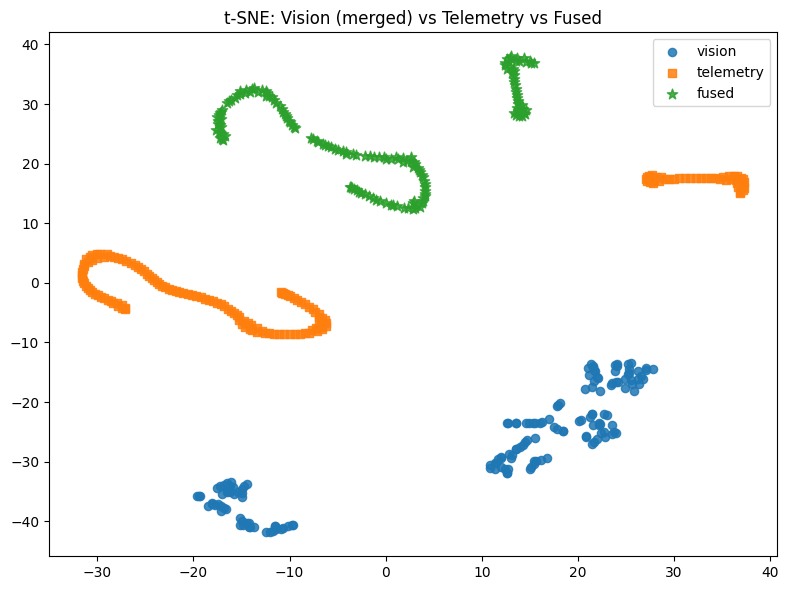

Saved: ./outputs/tsne_vision_tel_fused.png


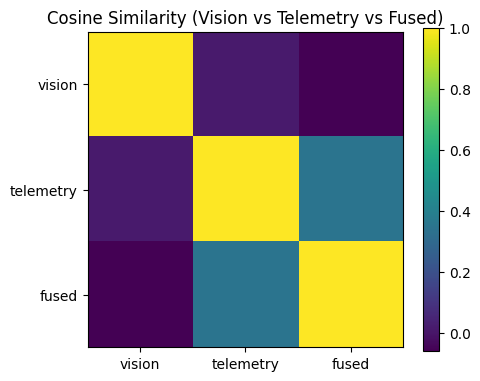

Saved: ./outputs/cosine_vision_tel_fused.png


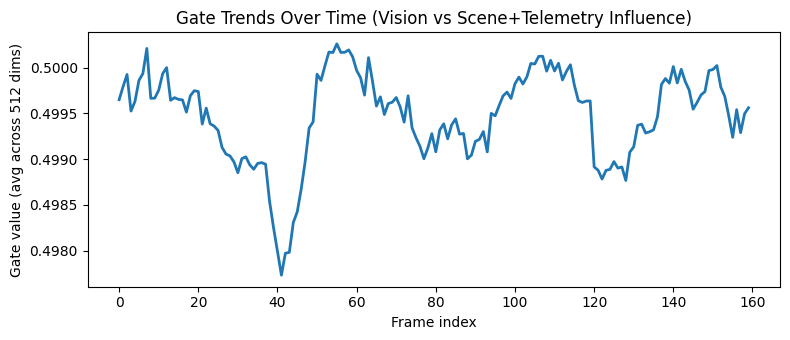

Saved: ./outputs/gate_trends_final.png


In [34]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import os

# --- t-SNE: only (vision merged, telemetry, fused) ---
subset = min(200, H.shape[0])
idx = np.arange(subset)

X = torch.cat([h_vis_all[idx], h_tel[idx], H[idx]], dim=0).cpu().numpy()
labels = (["vision"]*subset + ["telemetry"]*subset + ["fused"]*subset)

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            perplexity=20, random_state=SEED)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
for name, marker in [("vision","o"), ("telemetry","s"), ("fused","*")]:
    sel = [i for i,l in enumerate(labels) if l==name]
    plt.scatter(X2[sel,0], X2[sel,1], label=name,
                s=60 if name=="fused" else 35, alpha=0.85, marker=marker)
plt.legend()
plt.title("t-SNE: Vision (merged) vs Telemetry vs Fused")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "tsne_vision_tel_fused.png"), dpi=160)
plt.show()
print("Saved:", os.path.join(OUTPUT_DIR, "tsne_vision_tel_fused.png"))
# --- Cosine (means): 3 modalities only ---
means = np.stack([
    h_vis_all.mean(0).cpu().numpy(),
    h_tel.mean(0).cpu().numpy(),
    H.mean(0).cpu().numpy()
], axis=0)
C = cosine_similarity(means)

plt.figure(figsize=(5,4))
plt.imshow(C, interpolation="nearest")
plt.colorbar()
plt.xticks(range(3), ["vision","telemetry","fused"])
plt.yticks(range(3), ["vision","telemetry","fused"])
plt.title("Cosine Similarity (Vision vs Telemetry vs Fused)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "cosine_vision_tel_fused.png"), dpi=160)
plt.show()
print("Saved:", os.path.join(OUTPUT_DIR, "cosine_vision_tel_fused.png"))
# --- Gate Trends Plot (unchanged gating, just visualization) ---

# G is the gate output from:
#    H, G = fusion(h_img, h_scene, h_tel)
# G.shape = [N, 512]

# Compute average gate strength per frame
g_scalar = G.mean(dim=1).detach().cpu().numpy()   # [N]

plt.figure(figsize=(8,3.5))
plt.plot(g_scalar, linewidth=2)
plt.xlabel("Frame index")
plt.ylabel("Gate value (avg across 512 dims)")
plt.title("Gate Trends Over Time (Vision vs Scene+Telemetry Influence)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "gate_trends_final.png"), dpi=160)
plt.show()

print("Saved:", os.path.join(OUTPUT_DIR, "gate_trends_final.png"))



This notebook follows your diagram exactly up to the **Adapter** step (no LLM inference):
1. **Image → Vision Encoder (BLIP‑2 proxy: CLIP/ResNet)**
2. **Image → SegFormer (scene context)** *(falls back to deterministic stats if unavailable)*
3. **Merge Vision Embeddings:** `concat([E_img, E_scene]) → Linear → h_vis ∈ ℝ^{1×512}`
4. **Telemetry → MLP → h_tel ∈ ℝ^{1×512}`
5. **Project to 512-D:** map all modality embeddings to a shared latent
6. **Gated Fusion:** `g = σ(W_g [h_img || h_scene || h_tel]); H = ReLU(g ⊙ h_img + (1-g) ⊙ (h_scene + h_tel))`
7. **Adapter:** `W_adp: 512 → d_LLM` (we stop here)
8. **Visualizations:** t-SNE, cosine heatmap, gate trends